# Machine Learning Final Project: San Francisco Crime Classification



##Team Members:
David Medina - ID: 88562995 <br>
Jesus Hernandez - ID: 80629917



## Objective<br>
The dataset that was decided upon for this project is that of the **San Francisco Crime Classification**. <br>

The dataset contains incidents derived from SFPD Crime Incident Reporting system from 1/1/2003 to 5/13/2015. <br>

The objective at hand is that of predicting the probability distribution over a set of crime categories.

Link to the Kaggle competition: https://www.kaggle.com/competitions/sf-crime/code

# Loading the Dataset and Setting up the Notebook

To load a dataset from kaggle it is necessary to have and API token. To obtain one, register to kaggle and go to account, there the option to create a new API token will appear. Once it has been created simply upload it to the files of this google colab notebook.

In [ ]:
# Importing the libraries we'll use below
import time
import pandas as pd
from shapely.geometry import Point
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import files
from tensorflow import keras
from keras import metrics
from logging import WARN
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

!pip install geopandas
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 1.0 MB 7.5 MB/s 
     |████████████████████████████████| 6.3 MB 45.6 MB/s 
     |████████████████████████████████| 16.7 MB 216 kB/s 


Download and unzip the training and testing dataset files.

In [ ]:
# Upload the required kaggle.json API token file
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [ ]:
# Download San Francisco Crime Classification data and unzip it
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c sf-crime
!unzip sf-crime.zip
!unzip train.csv.zip
!unzip test.csv.zip
!unzip sampleSubmission.csv.zip

rm: cannot remove '/root/.kaggle': No such file or directory
 61% 25.0M/40.9M [00:00<00:00, 96.3MB/s]
100% 40.9M/40.9M [00:00<00:00, 123MB/s] 
Archive:  sf-crime.zip
  inflating: sampleSubmission.csv.zip  
  inflating: test.csv.zip            
  inflating: train.csv.zip           
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    


Convert train.csv file into pandas dataframes for us to work with.

In [ ]:
train_data = pd.read_csv("train.csv")
train_data.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


Convert test.csv file into pandas dataframes for us to work with.

Notice that in the training data, we have two additional attributes that the test data does not have which are: **[Category]**, **[Descript]**, and **[Resolution]**.

In [ ]:
test_data = pd.read_csv("test.csv")
test_data.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


# Understanding the Data and Basic Data Analysis



The San Frandisco Crime Classification (SFCC) dataset consists of 1,762,311 entries of crime reports. Each report is associated with 1 of the 39 possible categories. The dataset has been split by the creators, with 878,049 training reports and 884,262 test reports.

The training datasets has the following attributes:

* **Dates** - timestamp of the crime incident
* **Category** - category of the crime incident (only in train.csv). This is the **target** value.
* **Descript** - detailed description of the crime incident (only in train.csv)
* **DayOfWeek** - the day of the week
* **PdDistrict** - name of the police department district
* **Resolution** - how the crime incident was resolved (only in train.csv)
* **Address** - the approximate street address of the crime incident
* **X** - Longitude   
* **Y** - Latitude

Once again, **notice** that in the training data, we have three additional attributes that the test data does not have which are: **[Category]**, **[Descript]**, and **[Resolution]**.

The **[Descript]** feature contains information detailing as to why a given report falls into a given category. On the same note, the **[Category]** feature is our target attribute for our classification task and as such, both are missing from the testing dataset in order to see how well our models perform on it. The same is true for the **[Resolution]** attribute.

Due to no available true labels for the test dataset we will be working mostly with the training set of 878,049 examples. In order to see how accurate our created models are without the use of a replacement x_test and y_test set will be created by taking 20% of the crime reports taken randomly from the training set.

The test dataset will still be used, creating predictions on it and uploading it to the kaggle competition page in order to see how our models perform.

Shapes of the training and test data:

In [ ]:
print("The shape of <<train_data>> is:", train_data.shape)
print("The shape of the <<test_data>> is:", test_data.shape)

The shape of <<train_data>> is: (878049, 9)
The shape of the <<test_data>> is: (884262, 7)


Unique values for -> **[DayOfWeek]**

In [ ]:
unique_days = train_data["DayOfWeek"].unique()
print(unique_days)

['Wednesday' 'Tuesday' 'Monday' 'Sunday' 'Saturday' 'Friday' 'Thursday']


Unique values for -> **[Address]**

In [ ]:
unique_addresses = train_data["Address"].unique()
print(unique_addresses)

['OAK ST / LAGUNA ST' 'VANNESS AV / GREENWICH ST'
 '1500 Block of LOMBARD ST' ... '300 Block of JOHN F KENNEDY DR'
 'FOLSOM ST / ZENO PL' '1000 Block of 22ND AV']


Unique values for -> **[PdDistrict]**

In [ ]:
unique_pd_districts = train_data["PdDistrict"].unique()
print(unique_pd_districts)

['NORTHERN' 'PARK' 'INGLESIDE' 'BAYVIEW' 'RICHMOND' 'CENTRAL' 'TARAVAL'
 'TENDERLOIN' 'MISSION' 'SOUTHERN']


Identifying our target variable to predict --> **[Category]**

In [ ]:
target_values = train_data["Category"].unique()
print(target_values)

['WARRANTS' 'OTHER OFFENSES' 'LARCENY/THEFT' 'VEHICLE THEFT' 'VANDALISM'
 'NON-CRIMINAL' 'ROBBERY' 'ASSAULT' 'WEAPON LAWS' 'BURGLARY'
 'SUSPICIOUS OCC' 'DRUNKENNESS' 'FORGERY/COUNTERFEITING' 'DRUG/NARCOTIC'
 'STOLEN PROPERTY' 'SECONDARY CODES' 'TRESPASS' 'MISSING PERSON' 'FRAUD'
 'KIDNAPPING' 'RUNAWAY' 'DRIVING UNDER THE INFLUENCE'
 'SEX OFFENSES FORCIBLE' 'PROSTITUTION' 'DISORDERLY CONDUCT' 'ARSON'
 'FAMILY OFFENSES' 'LIQUOR LAWS' 'BRIBERY' 'EMBEZZLEMENT' 'SUICIDE'
 'LOITERING' 'SEX OFFENSES NON FORCIBLE' 'EXTORTION' 'GAMBLING'
 'BAD CHECKS' 'TREA' 'RECOVERED VEHICLE' 'PORNOGRAPHY/OBSCENE MAT']


Visualizing the quantity of each type of crime.

We can observe that the dataset isn't balanced and there are many more reports of certain categories such as Larceny/Theft or Other Offenses. It must be noted that this may skew our models due to models better learning how to identify certain categories over others.

In [ ]:
# Function that will display a histogram plot of crime counts
def visualization_crime(value, tight=False):
    with plt.style.context('fivethirtyeight'):
        fig, ax = plt.subplots(1, 1, figsize=(19, 6))
        sns.histplot(x=value, data=train_data, kde=True, palette='rocket', ax=ax)
        ax.tick_params(axis='x', rotation=90)
        if tight == True:
            fig.tight_layout()

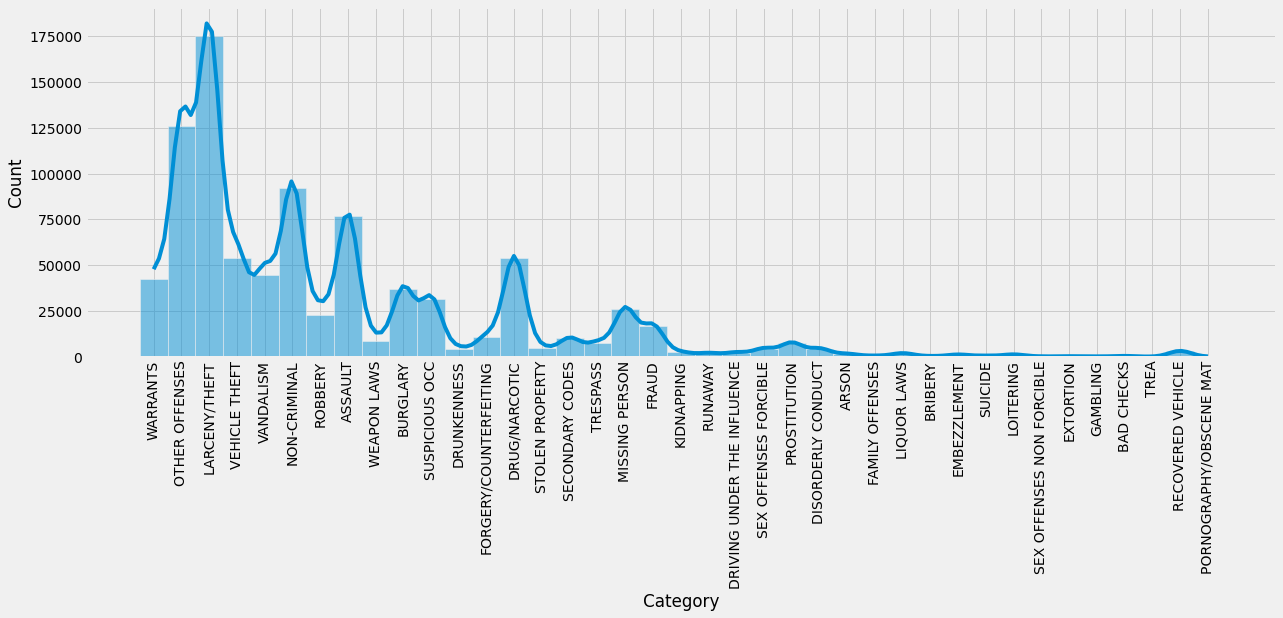

In [ ]:
# Printing out the histagram plot of crime counts
visualization_crime("Category", tight=False)

# Preprocessing Data & Feature Engineering

Before training any model, we must also perform some preprosesing to clean and feature engineering to prepare our data in order for our models to better learn the given information.

Since we will not be using the **[Descript]**, and **[Resolution]** attributes from the training data we will be droping them.

In [ ]:
train_data = train_data.drop(columns=["Descript", "Resolution"])

Drop **[Id]** attribute from test data since we will not be using it either.

In [ ]:
test_data = test_data.drop(columns=["Id"])

Now we will be looking for records that are duplicated.

In [ ]:
train_data.duplicated().sum()

65459

Train data without the **[Descript]**, and **[Resolution]** columns appears to contain 65,459 duplicates that we should remove.

In [ ]:
train_data.drop_duplicates(inplace=True)
print("Train data without duplicates shape:", train_data.shape)

Train data without duplicates shape: (812590, 7)


Additionally to removing duplicates we also took a look at the coordinates attribute and found that some of them are missplaced.

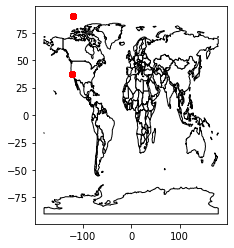

In [ ]:
def create_gdf(df):
    gdf = df.copy()
    gdf['Coordinates'] = list(zip(gdf.X, gdf.Y))
    gdf.Coordinates = gdf.Coordinates.apply(Point)
    gdf = gpd.GeoDataFrame(
        gdf, geometry='Coordinates', crs={'init': 'epsg:4326'})
    return gdf

train_gdf = create_gdf(train_data)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
train_gdf.plot(ax=ax, color='red')
plt.show()

All points should be in San Fransico but some of them are missplaced higher up north. To solve this we will replace the outlying coordinates with the average coordinates of the police district they belong.

In [ ]:
# Replace outliers of X and Y
train_data.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)
test_data.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)

imp = SimpleImputer(strategy='mean')

for district in train_data['PdDistrict'].unique():
    train_data.loc[train_data['PdDistrict'] == district, ['X', 'Y']] = imp.fit_transform(
        train_data.loc[train_data['PdDistrict'] == district, ['X', 'Y']])
    test_data.loc[test_data['PdDistrict'] == district, ['X', 'Y']] = imp.transform(
        test_data.loc[test_data['PdDistrict'] == district, ['X', 'Y']])



Convert the **[Dates]** attribute into multiple usable attributes and drop the original attribute since it will no longer be needed. This will help by making the date attribute more dynamic. Additionally we will also change the **[DayOfWeek]** attribute to numerical data since it is easier to manipulate.

*   **[Minutes]** - At what minute did the crime occur
*   **[Hour]** - At what hour did the crime occur
*   **[Day]** - In what day in the month did the crime occur
*   **[Month]** - In which month did the crime occur
*   **[Year]** - In what year did the crime occur
*   **[DayOfWeek]** - In which day of the week did the crime occur

Convert the **[Address]** attribute into multiple usable attributes and drop the original adress attribute. This is to see if the crime occured in a block or street.

*   **[Block]** - Becomes a 1 if the address contains a block, 0 otherwise
*   **[ST]** - Becomes a 1 if the address contains a street, 0 otherwise

In [ ]:
def feature_engineering(dataset):

  # Converting the [Dates] and [DayOfWeek] attributes
  dataset['Dates'] = dataset['Dates'].astype('datetime64[ns]')
  dataset['Minute'] = dataset.Dates.dt.minute
  dataset['Hour'] = dataset.Dates.dt.hour
  dataset['Day'] = dataset.Dates.dt.day
  dataset['Month'] = dataset.Dates.dt.month
  dataset['Year'] = dataset.Dates.dt.year
  dataset['DayOfWeek'] = dataset.Dates.dt.weekday

  # Converting the [Address] attribute
  dataset['Block'] = dataset['Address'].str.contains('block', case=False).apply(lambda x: 1 if x == True else 0)
  dataset['ST'] = dataset['Address'].str.contains('ST', case=False).apply(lambda x: 1 if x == True else 0)

  # Dropping the original [Dates] attribute since it will no longer be useful to us
  dataset = dataset.drop("Dates", axis=1)

  # Dropping the original [Address] attribute since it will no longer be useful to us
  dataset = dataset.drop("Address", axis=1)

  return dataset

In [ ]:
train_data = feature_engineering(train_data)
test_data = feature_engineering(test_data)

Similarly to changing the **[DayOfWeek]** attribute into numerical data, the same will be done for **[PdDistrict]**.

In [ ]:
le1 = LabelEncoder()
train_data['PdDistrict'] = le1.fit_transform(train_data['PdDistrict'])
test_data['PdDistrict'] = le1.transform(test_data['PdDistrict'])

Vizualizing the modified training and testing data now that preprocessing and feature engineering has been completed.

In [ ]:
train_data.head()

,Category,DayOfWeek,PdDistrict,X,Y,Minute,Hour,Day,Month,Year,Block,ST
0,WARRANTS,2,4,-122.425892,37.774599,53,23,13,5,2015,0,1
1,OTHER OFFENSES,2,4,-122.425892,37.774599,53,23,13,5,2015,0,1
2,OTHER OFFENSES,2,4,-122.424363,37.800414,33,23,13,5,2015,0,1
3,LARCENY/THEFT,2,4,-122.426995,37.800873,30,23,13,5,2015,1,1
4,LARCENY/THEFT,2,5,-122.438738,37.771541,30,23,13,5,2015,1,1


In [ ]:
test_data.head()

,DayOfWeek,PdDistrict,X,Y,Minute,Hour,Day,Month,Year,Block,ST
0,6,0,-122.399588,37.735051,59,23,10,5,2015,1,0
1,6,0,-122.391523,37.732432,51,23,10,5,2015,0,1
2,6,4,-122.426002,37.792212,50,23,10,5,2015,1,1
3,6,2,-122.437394,37.721412,45,23,10,5,2015,1,1
4,6,2,-122.437394,37.721412,45,23,10,5,2015,1,1


# Splitting Training Data and Baselining

Now that our data is ready we are now able to split the training data into our desired x_train, y_train, x_test and y_test sets to work with our models.

The **[Category]** attribute will be replaced with numerical values as has been seen before.

In [ ]:
# Drop [Category] to obtain our attributes
x = train_data.drop(columns=["Category"])

# Transform [Category] into our labels
le2 = LabelEncoder()
y = le2.fit_transform(train_data['Category'])

# Spliting trainig data into train (80%) and test (20%) subsets.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

Observing x_train

In [ ]:
print(x_train.head())
print("\nShape of <<x_train>>:", x_train.shape)

        DayOfWeek  PdDistrict           X          Y  Minute  Hour  Day  \
234090          4           7 -122.422526  37.771596      30     6   23   
207981          3           3 -122.423534  37.763138      49     3    9   
841525          3           7 -122.405400  37.781208      15    20   26   
725339          6           1 -122.407413  37.787407      40     5   30   
456926          6           8 -122.492832  37.743214       1     0   30   

        Month  Year  Block  ST  
234090      3  2012      0   1  
207981      8  2012      1   1  
841525      6  2003      1   1  
725339      1  2005      1   1  
456926     11  2008      1   0  

Shape of <<x_train>>: (650072, 11)


Observing y_train

In [ ]:
print(y_train)
print("\nShape of <<y_train>>:", y_train.shape)

[16 16 16 ... 20  4 21]

Shape of <<y_train>>: (650072,)


Observing x_test

In [ ]:
print(x_test.head())
print("\nShape of <<x_test>>:", x_test.shape)

        DayOfWeek  PdDistrict           X          Y  Minute  Hour  Day  \
454627          5           2 -122.439274  37.717556       0     8   13   
620086          3           7 -122.405832  37.785745      15    18   27   
346569          1           2 -122.436750  37.721992      40    10   27   
219482          0           7 -122.404385  37.772196      49    11   11   
306565          2           7 -122.413564  37.779514      10    21   23   

        Month  Year  Block  ST  
454627     12  2008      1   1  
620086      7  2006      0   1  
346569      7  2010      1   1  
219482      6  2012      1   1  
306565      2  2011      1   1  

Shape of <<x_test>>: (162518, 11)


Observing y_test

In [ ]:
print(y_test)
print("\nShape of <<y_test>>:", y_test.shape)

[ 1 20 21 ...  4 37 13]

Shape of <<y_test>>: (162518,)


When dealing with classification problems, we need something to base our predictions on, a baseline. A simple, but useful one is to select the majority class (the most common label in the training set) and use it as the prediction for all inputs.

Our training data consists of 172,607 **Larceny/Theft** examples and 639,983 **Non-Larceny/Theft** examples.

In [ ]:
most_common_crime = train_data['Category'].mode()
target = [most_common_crime[0]]
target_counts = train_data['Category'].isin(target).value_counts()

print("The most common crime is", most_common_crime[0], "with a count of", target_counts[1],"\n")
print(most_common_crime[0] + "COUNTS:\n" + str(target_counts))

The most common crime is LARCENY/THEFT with a count of 172607 

LARCENY/THEFTCOUNTS:
False    639983
True     172607
Name: Category, dtype: int64


Since the most common category is **Larceny/Theft**, we will make a new pandas dataframe where the column of the same name is filled with 1's. Then after submitting it to kaggle we will obtain a score that will be our baseline.

In [ ]:
# Obtain sample submission file that comes with dataset and vizualize it
sample_submission = pd.read_csv("sampleSubmission.csv")
sample_submission.head()

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# Sample submission [Warrants] comes filled with 1's, replace them with 0's and
# replace [Larceny/Theft] with 1's
sample_submission['WARRANTS'] = sample_submission['WARRANTS'].replace(1, 0)
sample_submission['LARCENY/THEFT'] = sample_submission['LARCENY/THEFT'].replace(0, 1)

# Export baseline dataframe to csv
sample_submission.to_csv('baseline.csv', index_label='Id')

Here is the score given by Kaggle for the submited baseline, our goal is for our models to perform better than this by having a lower score. <br><br>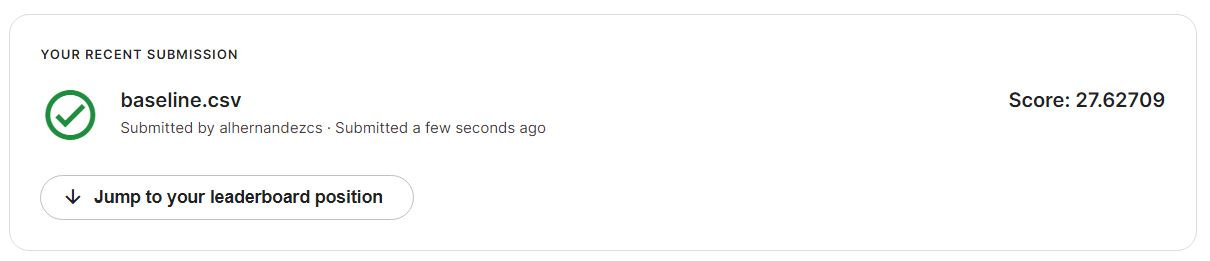


# Models

### Random Forest Classifier

Train Accuracy:  0.35606978919258175
Test Accuracy:  0.3038494197565808 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       316
           1       0.17      0.16      0.16     13560
           2       0.00      0.00      0.00        79
           3       0.00      0.00      0.00        47
           4       0.23      0.05      0.08      7241
           5       0.19      0.03      0.05       841
           6       0.00      0.00      0.00       444
           7       0.31      0.31      0.31      7882
           8       0.00      0.00      0.00       837
           9       0.00      0.00      0.00       232
          10       0.00      0.00      0.00        55
          11       0.00      0.00      0.00       101
          12       0.16      0.02      0.03      1987
          13       0.24      0.01      0.02      3213
          14       0.00      0.00      0.00        27
          15       0.00      0.00      0.00       452
       

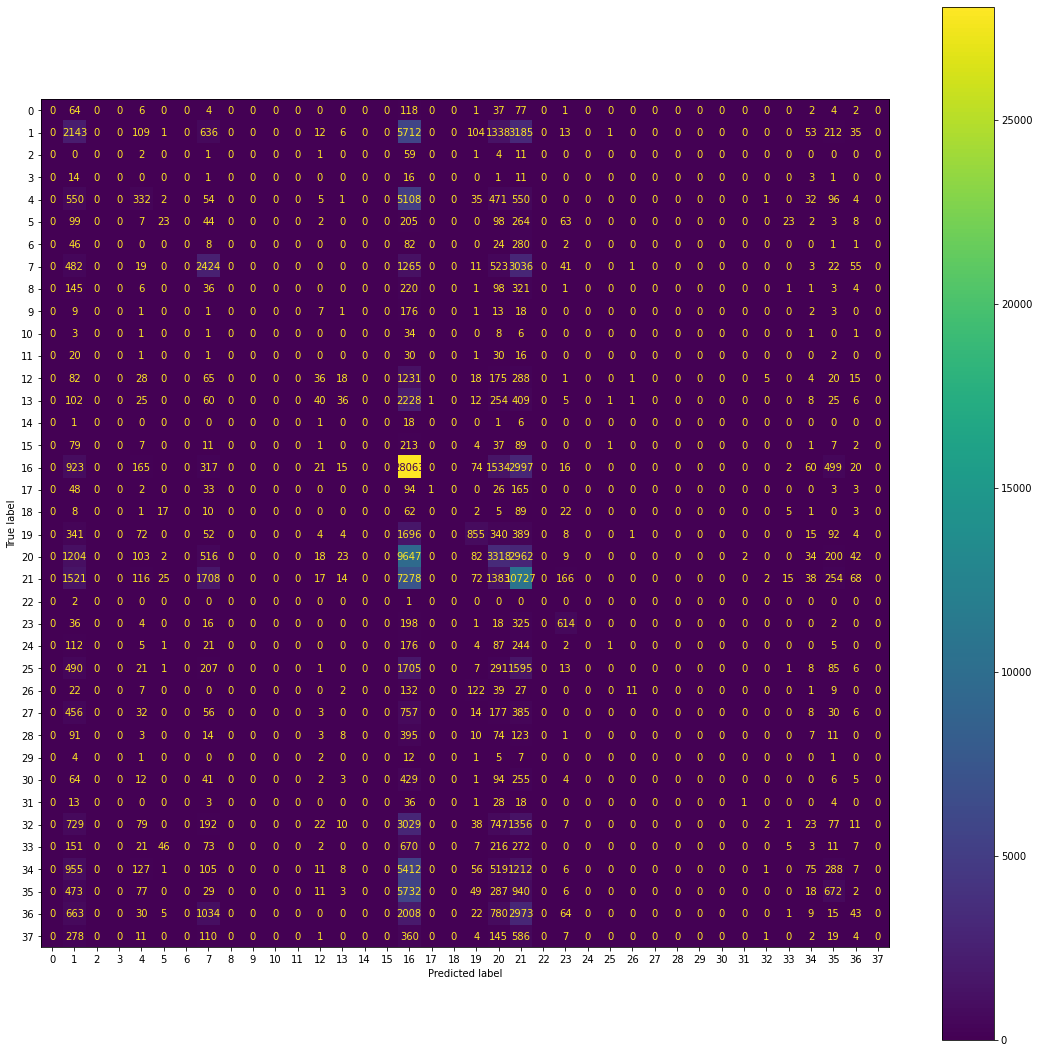

In [ ]:
# Creating our Random Forest Model
rfc = RandomForestClassifier(n_estimators=40, min_samples_split=100)

# Fit trainig data
rfc.fit(x_train, y_train)

# Predicting y_pred
rfc_pred = rfc.predict(x_test)

# Computing training accuracy
print("Train Accuracy: ", accuracy_score(y_train, rfc.predict(x_train)))

# Computing test accuracy
print("Test Accuracy: ", accuracy_score(y_test, rfc_pred), "\n")

# Printing classification report
print(classification_report(y_test, rfc_pred))

# Printing out fancy confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, rfc_pred))
fig, ax = plt.subplots(1, 1, figsize=(19, 19))
disp.plot(ax=ax);

Now that we see that our model works we can make predictions on the original test set (test_data) which consists of 884,262 test reports. Export these predictions to see how our model compares against models from other competitors on kaggle.

In [ ]:
# Predictions on original test data
pred = rfc.predict_proba(test_data)

# Convert results to pandas dataframe and visualize them
results = pd.DataFrame(pred, columns=le2.classes_)
results.head()

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0.003143,0.113250,0.0,0.000744,0.034891,0.001074,0.005769,0.037951,0.003434,0.001720,...,0.0,0.008296,0.001032,0.101542,0.0,0.017122,0.046885,0.064031,0.050341,0.032469
1,0.001751,0.050670,0.0,0.000000,0.002933,0.003232,0.012393,0.073545,0.002930,0.000000,...,0.0,0.007359,0.000000,0.049270,0.0,0.000348,0.017727,0.019178,0.061595,0.018861
2,0.010261,0.112872,0.0,0.000179,0.077970,0.000861,0.002494,0.028012,0.010391,0.000181,...,0.0,0.008416,0.000566,0.047505,0.0,0.014880,0.059672,0.037547,0.038305,0.006702
3,0.003335,0.144031,0.0,0.000625,0.022976,0.004368,0.003966,0.024355,0.014706,0.000000,...,0.0,0.011353,0.001083,0.061807,0.0,0.007095,0.063554,0.109082,0.064223,0.011635
4,0.003335,0.144031,0.0,0.000625,0.022976,0.004368,0.003966,0.024355,0.014706,0.000000,...,0.0,0.011353,0.001083,0.061807,0.0,0.007095,0.063554,0.109082,0.064223,0.011635


In [ ]:
# Export results to CSV file
results.to_csv('submission_rfc.csv', index_label='Id')

## Random Forest Classifier - Experiments, Explanation and Score

At first we didn't have a Random Forest Classifier, we were using a Decision Tree Classifier but believed that our model was not performing as desired with training accuracy scores coming at ~0.80 and testing accuracy score at ~0.16.

Due to this we decided to implement a Random Forest Classifier which are essentially more Desicion Trees Classifiers going over on various sub-samples of the dataset. Using this classifier should give us a more accurate prediction than that of any individual tree.

While it may seem at first that our accuracy scores are low with a score of .3570 on the training set and 0.3011 on the test set, these are good numbers. To see this, we just need to compare our results kaggle score against our baseline.

Here is our Kaggle score.



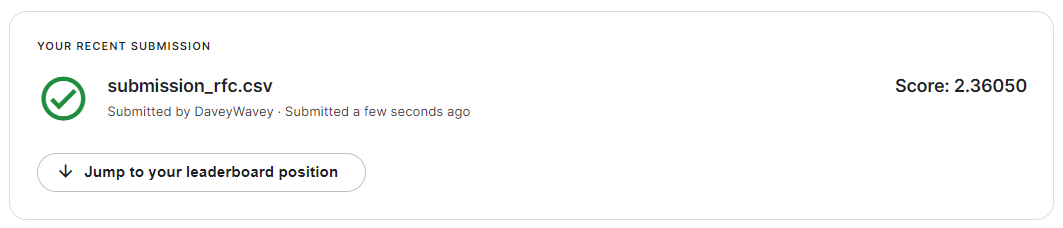

##K-Nearest Neighbors

Train Accuracy:  0.3605662142039651
Test Accuracy:  0.18807762832424715 

              precision    recall  f1-score   support

           0       0.01      0.01      0.01       316
           1       0.10      0.18      0.13     13560
           2       0.00      0.00      0.00        79
           3       0.00      0.00      0.00        47
           4       0.07      0.08      0.08      7241
           5       0.02      0.01      0.01       841
           6       0.01      0.00      0.00       444
           7       0.12      0.13      0.12      7882
           8       0.00      0.00      0.00       837
           9       0.00      0.00      0.00       232
          10       0.00      0.00      0.00        55
          11       0.00      0.00      0.00       101
          12       0.07      0.04      0.05      1987
          13       0.06      0.03      0.04      3213
          14       0.00      0.00      0.00        27
          15       0.02      0.00      0.00       452
       

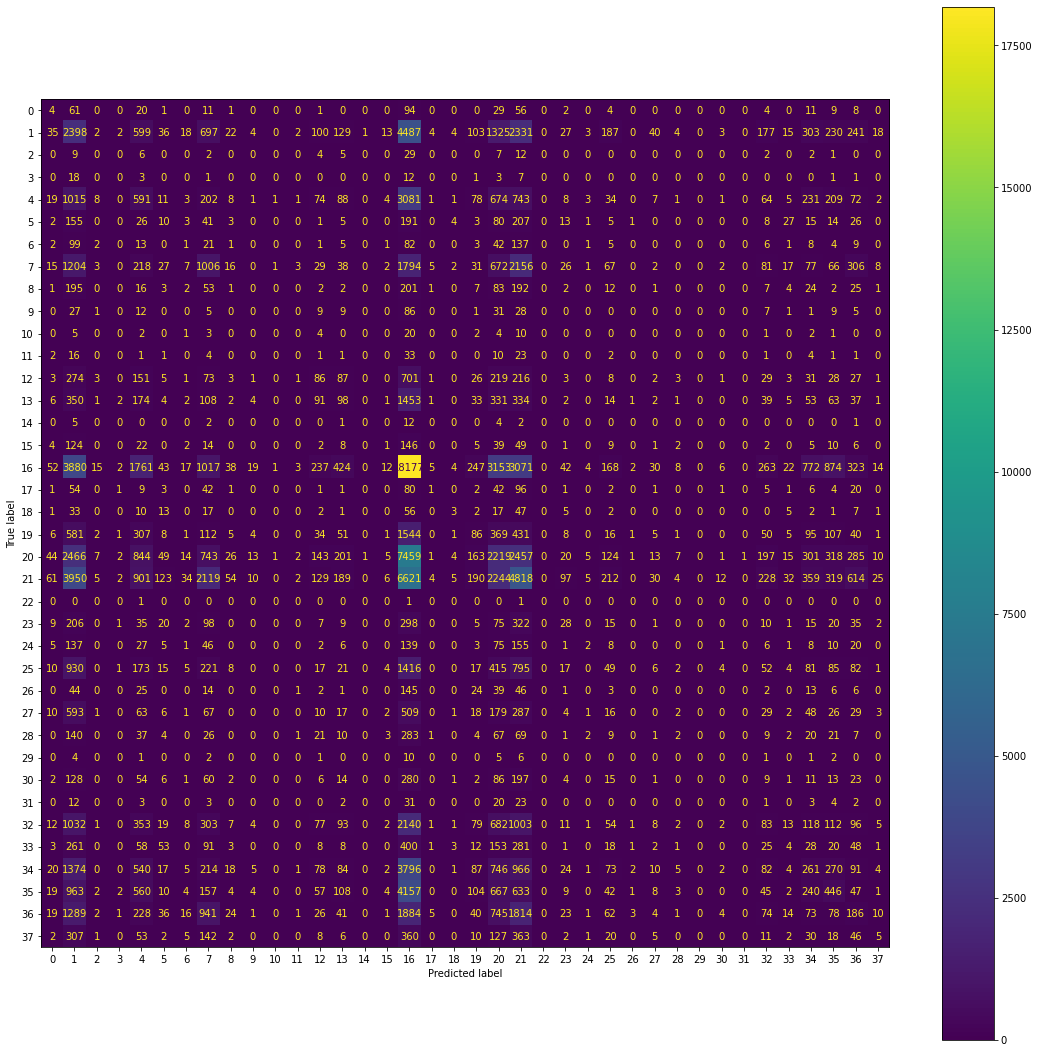

In [ ]:
# Creating our KNN model
knn = KNeighborsClassifier(n_neighbors=7)

# Fitting our KNN model
knn.fit(x_train, y_train)

# Keeping track of prediction time
start = time.time()

# Predicting y_pred
knn_pred = knn.predict(x_test)

# Computing training accuracy
print("Train Accuracy: ", accuracy_score(y_train, knn.predict(x_train)))

# Computing test accuracy
print("Test Accuracy: ", accuracy_score(y_test, knn_pred), "\n")

# Printing classification report
print(classification_report(y_test, knn_pred))

# Printing out fancy confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, knn_pred))
fig, ax = plt.subplots(1, 1, figsize=(19, 19))
disp.plot(ax=ax);

Same as with the Decision Tree model, we must make predictions on original test data set and prepare file for submnission to kaggle.

In [ ]:
# Obtain predictions on test data
pred = knn.predict_proba(test_data)

# Convert results to pandas dataframe and visualize them
results = pd.DataFrame(pred, columns=le2.classes_)

In [ ]:
# Export results to CSV file
results.to_csv('submission_knn.csv', index_label='Id')

## K-Nearest Neighbors - Experiments, Explanation and Score

K-Nearest Neighbors is by far the simplest machine learning model there is. Beacuse KNN does not necessarly learn a function and instead "memorizes" the training data, it is inherently a slow algorithm. This is also known as "lazy learning." Beacause of this, KNN took way longer to train compared to our other tested models. On average, each prediction took over 90 seconds more to train compared to random forests and feed-forward neural networks.
Here is our Kaggle score.

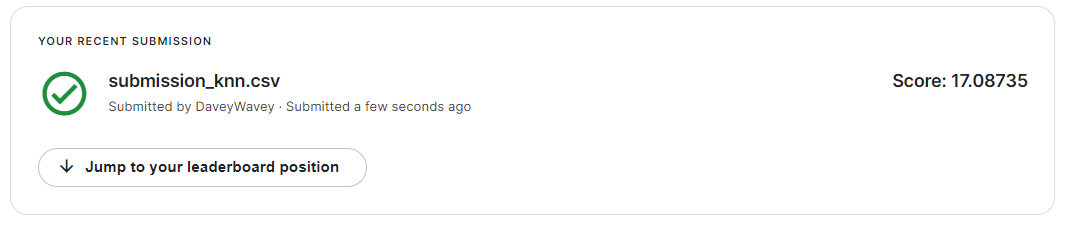

## Feed-Forward Neural Network

In [ ]:
# Plot loss of model across epochs
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [ ]:
def build_ffnn_softmax_model(n_classes, learning_rate=0.1):
  """Build a TF feed-forward neural network model using Keras.

  Args:
    n_classes: Number of classes in dataset
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()

  # Could seed afect in a relevant manner?
  tf.random.set_seed(0)

  # Add more layers, different types of them too
  model = keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
  ])

  # Change Optimizer
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Change type of loss and adjust learning rate
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer, 
                metrics=['accuracy'])

  return model

Epoch 1/5
4571/4571 [==============================] - 9s 2ms/step - loss: 2.8426 - accuracy: 0.2122 - val_loss: 2.6759 - val_accuracy: 0.2115
Epoch 2/5
4571/4571 [==============================] - 8s 2ms/step - loss: 2.6705 - accuracy: 0.2122 - val_loss: 2.6714 - val_accuracy: 0.2115
Epoch 3/5
4571/4571 [==============================] - 8s 2ms/step - loss: 2.6681 - accuracy: 0.2122 - val_loss: 2.6701 - val_accuracy: 0.2115
Epoch 4/5
4571/4571 [==============================] - 8s 2ms/step - loss: 2.6673 - accuracy: 0.2122 - val_loss: 2.6695 - val_accuracy: 0.2115
Epoch 5/5
4571/4571 [==============================] - 8s 2ms/step - loss: 2.6669 - accuracy: 0.2122 - val_loss: 2.6695 - val_accuracy: 0.2115


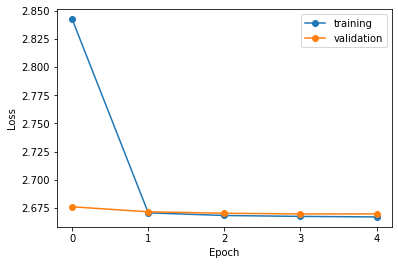

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 11)                0         
                                                                 
 dense (Dense)               (None, 5)                 60        
                                                                 
 dense_1 (Dense)             (None, 39)                234       
                                                                 
Total params: 294
Trainable params: 294
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_examples, num_features = x_train.shape

n_classes = len(np.bincount(y_train))

ffnn_softmax_model = build_ffnn_softmax_model(n_classes, 0.1)

ffnn_softmax_history = ffnn_softmax_model.fit(
  x = x_train,
  y = y_train,
  epochs=5,
  batch_size=128,
  validation_split=0.1,
  verbose=1)

ffnn_softmax_history = pd.DataFrame(ffnn_softmax_history.history)
plot_history(ffnn_softmax_history)
ffnn_softmax_model.summary()

Perform predictions on original test data set and prepare file for submnission to kaggle.

In [ ]:
# Obtain predictions on test data
pred = ffnn_softmax_model.predict(test_data)

# Convert results to pandas dataframe and visualize them
results = pd.DataFrame(pred, columns=le2.classes_)

# Export results to CSV file
results.to_csv('submission_ffnn.csv', index_label='Id')

In [ ]:
# Export results to CSV file
results.to_csv('submission_ffnn.csv', index_label='Id')

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive






### Feed Forward Neural Network - Experiments, Explanation and Score

Feed-Forward Neural Network thought us things that we didn't see at first from our data. At first our train data consisted of less features since we had removed also the **[Date]** and **[Description]** features as we didn't see a form to use them outside of embeddings. Our FFNN stagnated at an accuracy of ~0.17 for a long time until we found their use.

We tried many different optimizers, amount of layers, different types of layers, learning rates and more in order to better our results but found out that the best way to better them was to better understand our data. We also tried many normalization techniques but our lack of knowledge into the topic made their use on this project difficult.

Lessons obtained from the ordeal of improving our results on FFNN helped us in also improving our past models.

Here is our Kaggle score.

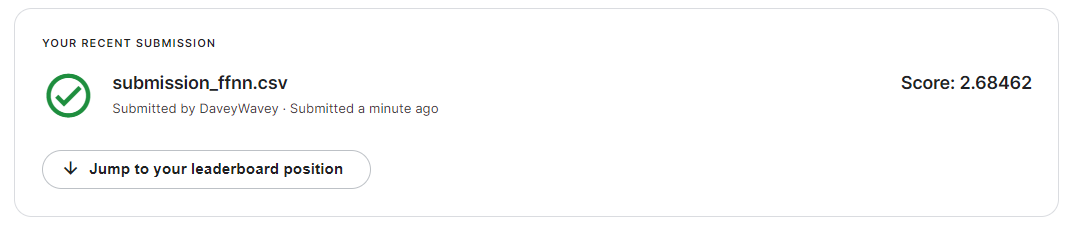

# Conclusion

This particular dataset presented us with various types of challenges. Converting non-numerical attributes to usable data was the first challenge we encountered. We quickly realized that the presented data had several attributes that contained words/strings. We began by noticing that the **[Dates]** attribute was actually a DateTime object. With this in mind, we were able to extract attributes that could provide insightful information such as day, hour, year, etc. In a similar fashion, we broke down the **[Address]** attribute by adding a 1 if a particular address was a street, block, circle, avenue, etc., and 0 otherwise. Attributes **[DayOfWeek]** and **[PdDistrict]** were mainly categorical and therefore, we decided to give each unique value an assigned integer. 

Another important step when it came to preprocessing our dataset, was to ensure that we discarded any duplicate examples as they wouldn't help us out in the long run. We decided to drop the **[Descript]** attribute as it contains different lengths of text for each different example. The **[Descript]** attribute also had words that were too similar to our target value **[Category]** which would often cause overfitting in models such as Decision Trees yielding high training accuracies and low testing accuracies. 

Lastly, attributes **[X]** and **[Y]** which depict coordinates in San Francisco, had outliers that were outside of the city-bound. To combat this issue, we decided to check if they landed within a particular police department district, take the mean of all coordinates in that district, and assign the outlier's coordinates with the mean value. This would ensure that there are no outliers in our data.

When we plotted a histogram plot describing the count/occurrences of each type of crime in San Francisco, we learned that the most common crime was that of **[LARCENY/THEFT]** with **[OTHER OFFENSES]** coming in second and **[NON-CRIMINAL]** coming in third. However, what we didn't realize at that given point was that we were working with a very unbalanced dataset which would provoke issues once we began training various models.

Knowing that our task involves multi-class classification, we decided to pick K-Nearest Neighbors, Regression Trees, and Feed-Forward Neural Networks to follow the order in which we learned about each type of model. All three of these models are capable of multi-class classification and are different enough for comparison. 

## Final Accuracies
|MODEL|TRAIN ACCURACY|TEST ACCURACY|KAGGLE SCORE|BEATED BASELINE|
|-|-|-|-|-|
|Random Forest|0.3560|0.3038|2.3605|Yes|
|K-Nearest Neighbors|0.3605|0.1880 |17.08735|Yes|
|Feed-Forward Neural Network|0.2122|0.2115|2.68462|Yes|

<br>Even though we might have not reached our desired accuracies, we have potential ideas on how we could improve the data if we hdings for the **[Descript]** attribute to give it meaning rather than just complad more time on our hands. One idea is to use padding and word embedetely discarding it. It is probable that this would increase the accuracies of our models. Another potential idea would be to apply principal component analysis (PCA) to reduce the dimensions of our data and hopefully allow our models to better train.

Another important potential idea on improvement is for how to deal with the high imbalance of our dataset. We desired to try new technologies such as the SMOTE (Synthetic Minority Oversampling Technique) that oversamples our training data in order to solve issues such as this, but we didn't have time to dive deeper into topics such as this.

Overall, this final project allowed us to apply all of our new skillsets learned throughout the semester to a real dataset. From analyzing the type of data we are working with, to feature engineering, and writting our first models. This was all possible through amazing instruction and a great introduction to machine learning.